In [1]:
pip install --upgrade numpy matplotlib pandas biopython tensorflow

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.4)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
     |████████████████████████████████| 2.3MB 3.4MB/s 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

## Load

In [3]:
from urllib.request import urlopen
from gzip import GzipFile
from io import TextIOWrapper
from Bio import SeqIO

coding_url = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/gencode.v34.pc_transcripts.fa.gz'
non_coding_url = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/gencode.v34.lncRNA_transcripts.fa.gz'

def load_fasta(url):
  response = GzipFile(fileobj=urlopen(url))
  return list(SeqIO.parse(TextIOWrapper(response), "fasta"))

coding_seq = load_fasta(coding_url)
non_coding_seq = load_fasta(non_coding_url)

print("Coding: {}".format(len(coding_seq)),
      "\nNon-Coding: {}".format(len(non_coding_seq)))

Coding: 100566 
Non-Coding: 48479


## Process Data

* Protein-coding transcript sequences = Class **0**
* Long non-coding RNA transcript sequences = Class **1**

In [4]:
coding_data = pd.DataFrame({'seq': [str(rec.seq) for rec in coding_seq], 'class': 0})
non_coding_data = pd.DataFrame({'seq': [str(rec.seq) for rec in non_coding_seq], 'class': 1})
data = pd.concat([coding_data, non_coding_data])
data

,seq,class
0,CCCAGATCTCTTCAGTTTTTATGCCTCATTCTGTGAAAATTGCTGT...,0
1,TCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTG...,0
2,AGCCCAGTTGGCTGGACCAATGGATGGAGAGAATCACTCAGTGGTA...,0
3,AGCCCAGTTGGCTGGACCAATGGATGGAGAGAATCACTCAGTGGTA...,0
4,CGGAGTCTCCCAAGTCCCCGCCGGGCGGGCGCGCGCCAGTGGACGC...,0
...,...,...
48474,TGCACACACCTTCTTTTCCAAGGTTTGTGTGCAGAACATCCTGCCC...,1
48475,CACACAACATGGCCTTCAGCAATGCTGATTCAGGCTTTGTGGATGC...,1
48476,GGTTGCCACTTCAAGGGACTACATCATGATGTCCTGTTTCTAATGA...,1
48477,GTCTAGGTGCAGAGGCCAGAGGAAGTCATTGCTGTCCTGTCCCGCC...,1


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['seq'], data['class'], random_state=0)
list(map(np.shape, [X_train , X_test, y_train, y_test]))

[(111783,), (37262,), (111783,), (37262,)]

In [6]:
y_train.value_counts()

0    75633
1    36150
Name: class, dtype: int64

In [7]:
y_test.value_counts()

0    24933
1    12329
Name: class, dtype: int64

In [0]:
del coding_seq, non_coding_seq, coding_data, non_coding_data, data

## Explore Training

Coding count     75633.000000
mean       2202.238441
std        2289.594253
min           8.000000
25%         708.000000
50%        1524.000000
75%        2895.000000
max      109224.000000
dtype: float64
Non-Coding count     36150.000000
mean       1325.706058
std        2229.211687
min          32.000000
25%         580.000000
50%         942.000000
75%        1631.000000
max      347561.000000
dtype: float64


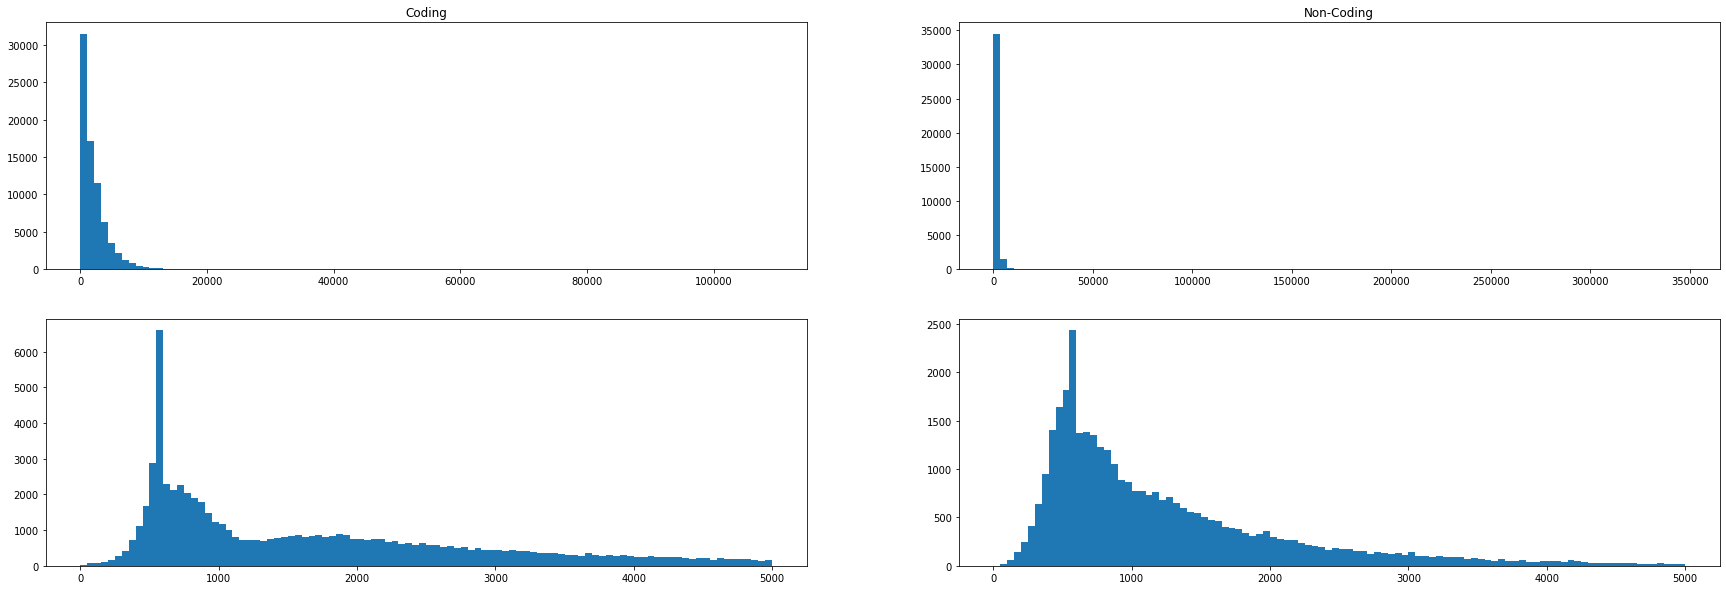

In [9]:
coding_sizes = pd.Series(map(len, X_train[y_train == 0]))
non_coding_sizes = pd.Series(map(len, X_train[y_train == 1]))

print("Coding", coding_sizes.describe())
print("Non-Coding", non_coding_sizes.describe())

fig, axs = plt.subplots(2, 2, figsize=(30, 10))
axs[0][0].hist(coding_sizes, bins=100)
axs[0][0].set_title("Coding")
axs[0][1].hist(non_coding_sizes, bins=100)
axs[0][1].set_title("Non-Coding")
axs[1][0].hist(coding_sizes, bins=100, range=(0, 5e3))
axs[1][1].hist(non_coding_sizes, bins=100, range=(0, 5e3))
plt.show()

del coding_sizes, non_coding_sizes

In [10]:
X_train.apply(lambda x: pd.Series(list(x)).value_counts()).sum()

C    51385261.0
G    52226675.0
A    57164995.0
T    53709240.0
N           3.0
dtype: float64

## Validation set

In [11]:
X_nn_train, X_val, y_nn_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
list(map(np.shape, [X_nn_train, X_val, y_nn_train, y_val]))

[(100604,), (11179,), (100604,), (11179,)]

In [12]:
y_nn_train.value_counts()

0    68061
1    32543
Name: class, dtype: int64

In [13]:
y_val.value_counts()

0    7572
1    3607
Name: class, dtype: int64

## Over-sampling

In [14]:
non_coding_ids = np.arange(len(y_nn_train))[y_nn_train == 1]
non_coding_choices = np.random.default_rng(0).choice(non_coding_ids, (len(y_nn_train[y_nn_train == 0]) - len(y_nn_train[y_nn_train == 1])))
X_train_over = pd.concat([X_nn_train, X_nn_train.iloc[non_coding_choices]]).sample(frac=1, random_state=2)
y_train_over = pd.concat([y_nn_train, y_nn_train.iloc[non_coding_choices]]).sample(frac=1, random_state=2)
del non_coding_ids, non_coding_choices
y_train_over.value_counts()

1    68061
0    68061
Name: class, dtype: int64

## Encode

In [0]:
base = ['A', 'T', 'C', 'G']
base_length = len(base)
seq_length = 512

def encode(seq):
  base_onehot = tf.eye(base_length)

  seq_array = tf.strings.bytes_split(seq)[:seq_length]
  seq_array = tf.pad(seq_array, [[0, seq_length - tf.shape(seq_array)[0]]])

  encoded_seq = tf.zeros((seq_length, base_length))
  for base_id, base_char in enumerate(base):
    mask_indices = tf.where(seq_array == base_char)
    encoded_seq = tf.tensor_scatter_nd_update(
      encoded_seq, mask_indices, tf.repeat([base_onehot[base_id]], tf.shape(mask_indices)[0], 0)
    )

  return encoded_seq

X_train_encoded = tf.data.Dataset.from_tensor_slices(X_train_over).map(encode)
y_train_encoded = tf.data.Dataset.from_tensor_slices(keras.utils.to_categorical(y_train_over))
dataset_encoded = tf.data.Dataset.zip((X_train_encoded, y_train_encoded))
dataset_encoded = dataset_encoded.batch(32)

X_val_encoded = tf.data.Dataset.from_tensor_slices(X_val).map(encode)
y_val_encoded = tf.data.Dataset.from_tensor_slices(keras.utils.to_categorical(y_val))
val_encoded = tf.data.Dataset.zip((X_val_encoded, y_val_encoded))
val_encoded = val_encoded.batch(256)

In [16]:
for i, seq in enumerate(X_train_over):
  length = len(seq)
  if (length < seq_length):
    print(i)
    print(len(X_train_over.iloc[i]), X_train_over.iloc[i][:10], X_train_over.iloc[i][length-5:length+5], y_train_over.iloc[i])
    X_first, y_first  = next(iter(dataset_encoded.unbatch().skip(i).take(1)))
    print(X_first.numpy()[:10])
    print(X_first.numpy()[length-5:length+5])
    print(y_first.numpy())
    break

4
450 CTTGGGACCT CTGGG 1
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[0. 1.]


## Model

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

https://www.researchgate.net/publication/301703031_DNA_Sequence_Classification_by_Convolutional_Neural_Network

https://www.researchgate.net/publication/327213391_DeepSF_Deep_Convolutional_Neural_Network_for_Mapping_Protein_Sequences_to_Folds

https://www.kaggle.com/sohaibanwaar1203/sequence-classification-using-deep-learning/notebook

In [0]:
keras.backend.clear_session()

In [18]:
model_fcc = keras.Sequential([
    keras.layers.Flatten(input_shape=(seq_length, base_length)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model_fcc.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC()])

model_fcc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 590,850
Trainable params: 590,850
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_conv = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=9, input_shape=(seq_length, base_length), activation='relu'),
    keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'),
    keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model_conv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC()])

model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 504, 64)           2368      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           10272     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 32)           5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 242, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 121, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 117, 16)          

In [20]:
for w in model_fcc.get_weights():
  print(w.shape)

(2048, 256)
(256,)
(256, 256)
(256,)
(256, 2)
(2,)


In [21]:
for w in model_conv.get_weights():
  print(w.shape)

(9, 4, 64)
(64,)
(5, 64, 32)
(32,)
(5, 32, 32)
(32,)
(5, 32, 32)
(32,)
(5, 32, 16)
(16,)
(5, 16, 16)
(16,)
(896, 128)
(128,)
(128, 2)
(2,)


## Train

In [22]:
model_fcc.fit(dataset_encoded, validation_data=val_encoded, epochs=2)

Epoch 1/2
4254/4254 [==============================] - 89s 21ms/step - loss: 0.5086 - accuracy: 0.7515 - auc: 0.8274 - val_loss: 0.4853 - val_accuracy: 0.7661 - val_auc: 0.8512
Epoch 2/2
4254/4254 [==============================] - 87s 20ms/step - loss: 0.3988 - accuracy: 0.8248 - auc: 0.9004 - val_loss: 0.4926 - val_accuracy: 0.7652 - val_auc: 0.8534


In [23]:
model_conv.fit(dataset_encoded, validation_data=val_encoded, epochs=8)

Epoch 1/8
4254/4254 [==============================] - 116s 27ms/step - loss: 0.4890 - accuracy: 0.7645 - auc_1: 0.8435 - val_loss: 0.3906 - val_accuracy: 0.8158 - val_auc_1: 0.9031
Epoch 2/8
4254/4254 [==============================] - 112s 26ms/step - loss: 0.3534 - accuracy: 0.8500 - auc_1: 0.9233 - val_loss: 0.3125 - val_accuracy: 0.8596 - val_auc_1: 0.9401
Epoch 3/8
4254/4254 [==============================] - 112s 26ms/step - loss: 0.3062 - accuracy: 0.8754 - auc_1: 0.9429 - val_loss: 0.2921 - val_accuracy: 0.8732 - val_auc_1: 0.9474
Epoch 4/8
4254/4254 [==============================] - 114s 27ms/step - loss: 0.2804 - accuracy: 0.8882 - auc_1: 0.9524 - val_loss: 0.2885 - val_accuracy: 0.8718 - val_auc_1: 0.9495
Epoch 5/8
4254/4254 [==============================] - 111s 26ms/step - loss: 0.2628 - accuracy: 0.8966 - auc_1: 0.9579 - val_loss: 0.3526 - val_accuracy: 0.8422 - val_auc_1: 0.9324
Epoch 6/8
4254/4254 [==============================] - 111s 26ms/step - loss: 0.2495 - acc

## Evaluate

In [0]:
X_test_encoded = tf.data.Dataset.from_tensor_slices(X_test).map(encode)
y_test_encoded = tf.data.Dataset.from_tensor_slices(keras.utils.to_categorical(y_test))
test_dataset_encoded = tf.data.Dataset.zip((X_test_encoded, y_test_encoded))
test_dataset_encoded = test_dataset_encoded.batch(256)

In [25]:
print(model_fcc.evaluate(test_dataset_encoded))
print(model_conv.evaluate(test_dataset_encoded))

146/146 [==============================] - 16s 109ms/step - loss: 0.4822 - accuracy: 0.7691 - auc: 0.8594
[0.4822152554988861, 0.7690677046775818, 0.8593753576278687]
146/146 [==============================] - 18s 123ms/step - loss: 0.3517 - accuracy: 0.8528 - auc_1: 0.9382
[0.35170048475265503, 0.852825939655304, 0.9381900429725647]


In [0]:
y_fcc_pred = np.argmax(model_fcc.predict(test_dataset_encoded), 1)
y_conv_pred = np.argmax(model_conv.predict(test_dataset_encoded), 1)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fcc_pred))
print(classification_report(y_test, y_conv_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81     24933
           1       0.61      0.85      0.71     12329

    accuracy                           0.77     37262
   macro avg       0.76      0.79      0.76     37262
weighted avg       0.81      0.77      0.78     37262

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     24933
           1       0.71      0.94      0.81     12329

    accuracy                           0.85     37262
   macro avg       0.84      0.88      0.84     37262
weighted avg       0.88      0.85      0.86     37262



## Visualize test

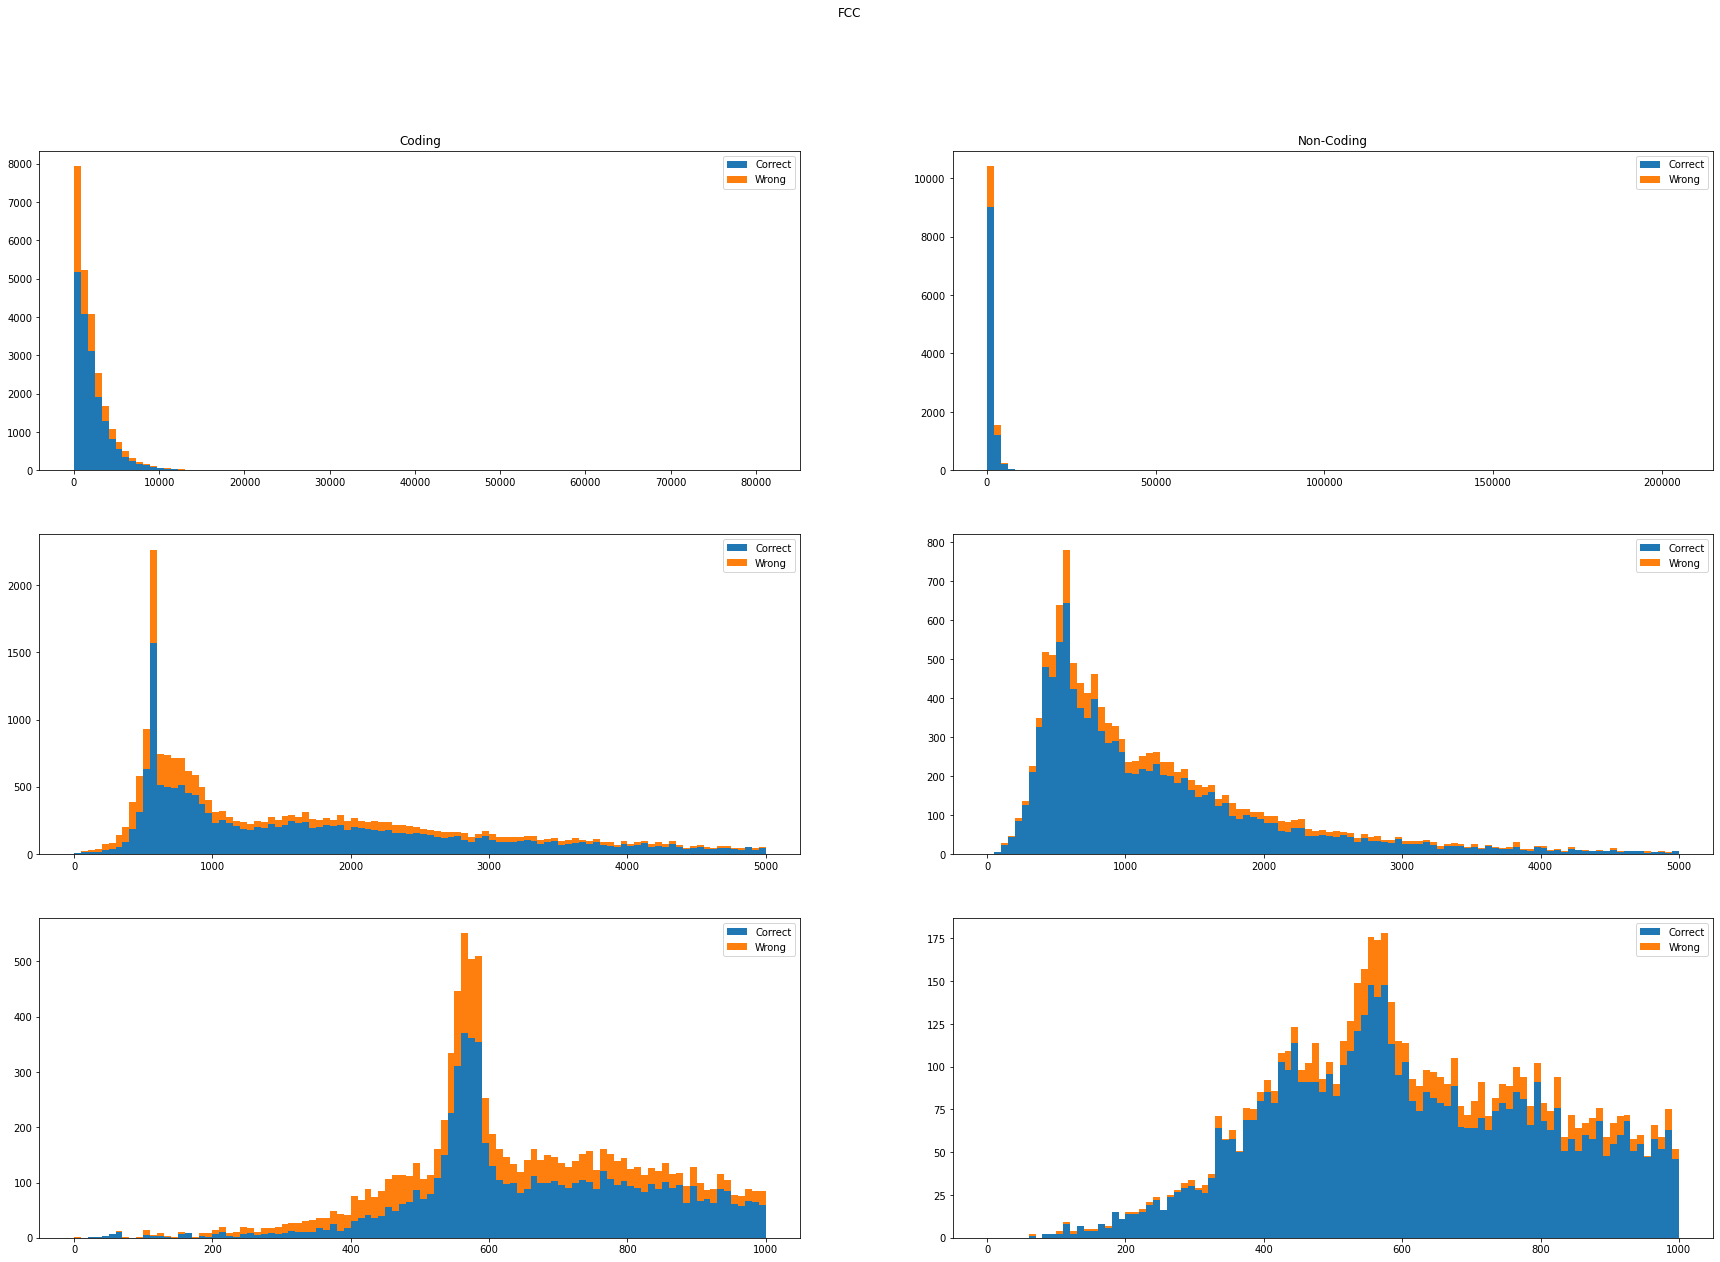

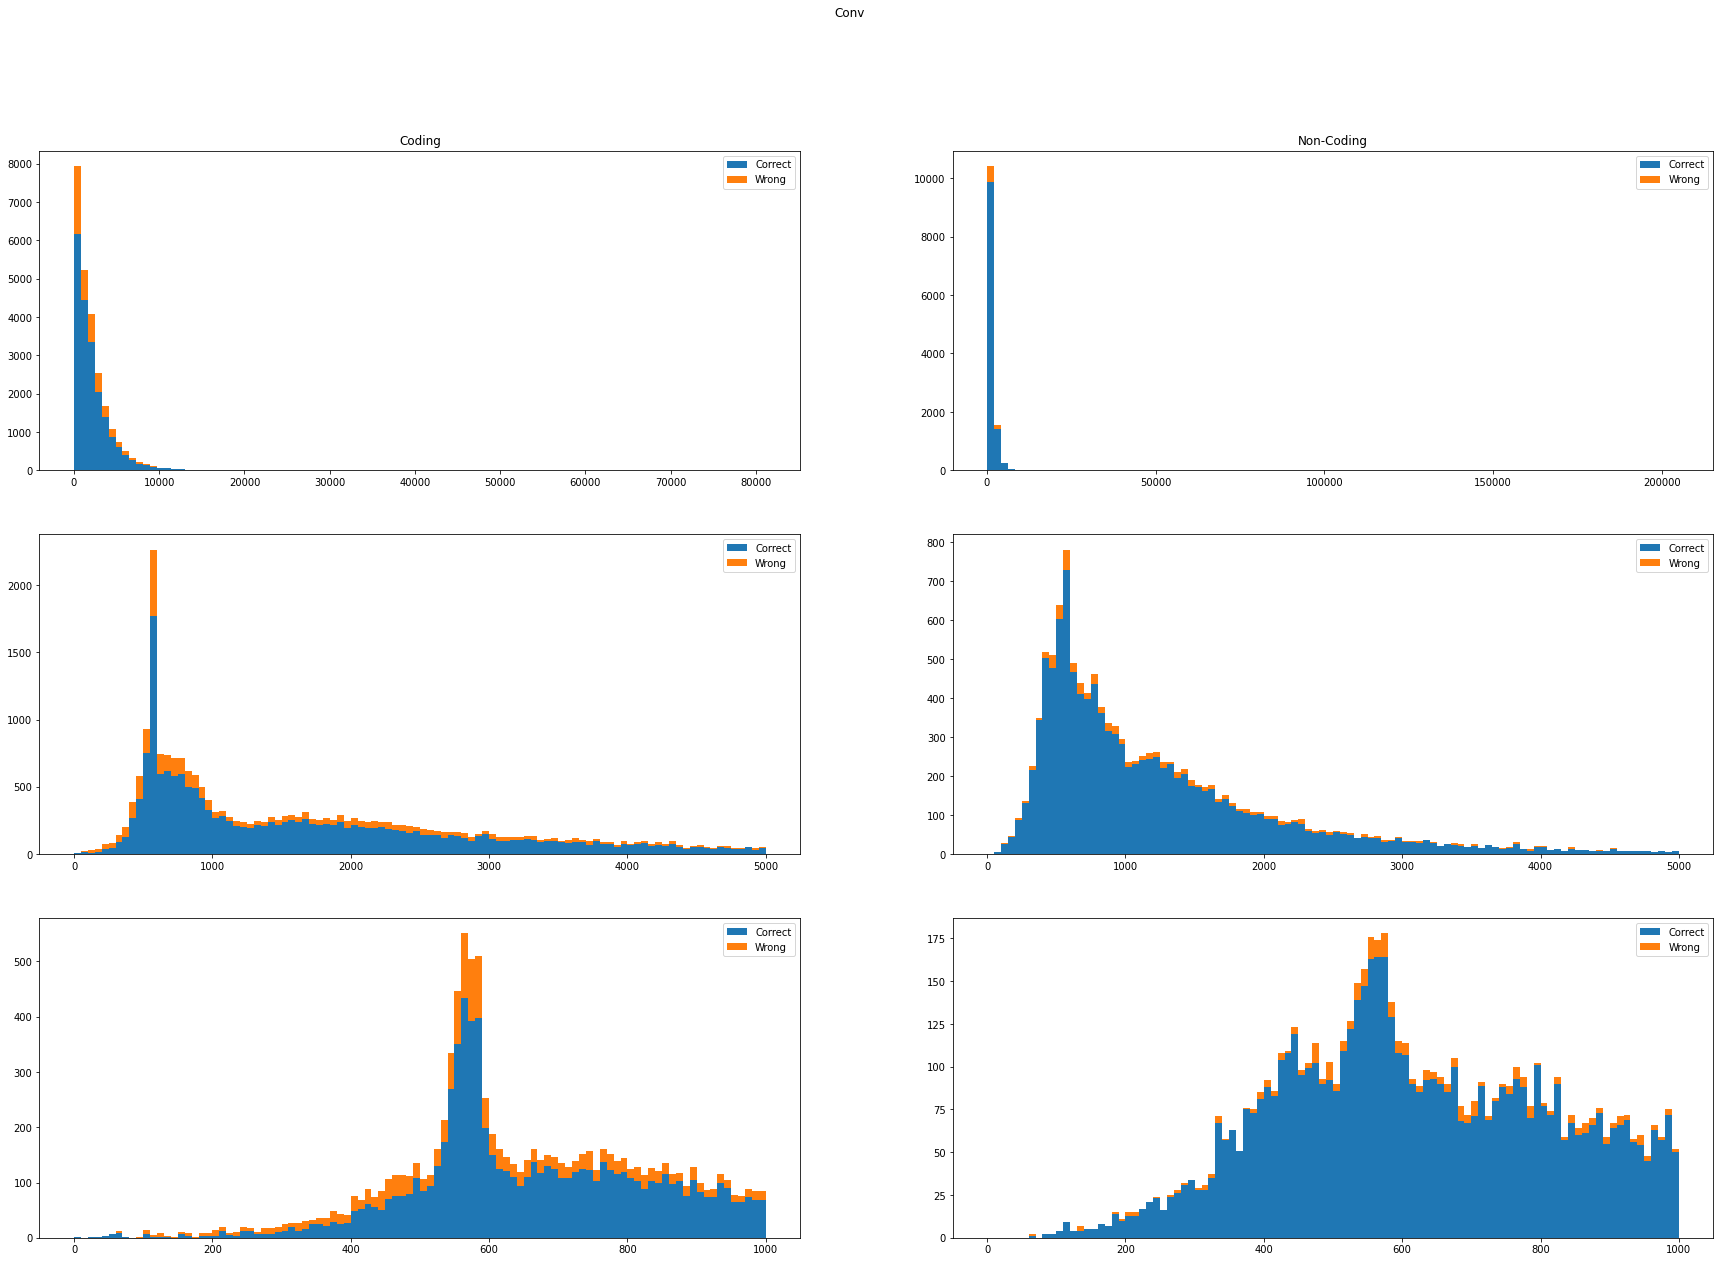

In [28]:
y_test_coding_mask = y_test == 0
y_test_non_coding_mask = y_test == 1

coding_sizes = pd.Series(map(len, X_test[y_test_coding_mask]))
non_coding_sizes = pd.Series(map(len, X_test[y_test_non_coding_mask]))

def plot_test(y_pred, title):
  coding_sizes_stack = [coding_sizes[y_pred[y_test_coding_mask] == 0], coding_sizes[y_pred[y_test_coding_mask] == 1]]
  non_coding_sizes_stack = [non_coding_sizes[y_pred[y_test_non_coding_mask] == 1], non_coding_sizes[y_pred[y_test_non_coding_mask] == 0]]

  labels = ['Correct', 'Wrong']

  fig, axs = plt.subplots(3, 2, figsize=(30, 20))
  plt.suptitle(title)
  axs[0][0].hist(coding_sizes_stack, bins=100, stacked=True, label=labels)
  axs[0][0].set_title("Coding")
  axs[0][1].hist(non_coding_sizes_stack, bins=100, stacked=True, label=labels)
  axs[0][1].set_title("Non-Coding")
  axs[1][0].hist(coding_sizes_stack, bins=100, stacked=True, range=(0, 5e3), label=labels)
  axs[1][1].hist(non_coding_sizes_stack, bins=100, stacked=True, range=(0, 5e3), label=labels)
  axs[2][0].hist(coding_sizes_stack, bins=100, stacked=True, range=(0, 1e3), label=labels)
  axs[2][1].hist(non_coding_sizes_stack, bins=100, stacked=True, range=(0, 1e3), label=labels)
  for ax in axs.flat:
    ax.legend()
  plt.show()

  del coding_sizes_stack, non_coding_sizes_stack

plot_test(y_fcc_pred, "FCC")
plot_test(y_conv_pred, "Conv")

del y_test_coding_mask, y_test_non_coding_mask, coding_sizes, non_coding_sizes